In [2]:
import obspy
import os
import matplotlib.pyplot as plt
from numpy import diff
import numpy as np
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras

In [1]:
import seisbench
import seisbench.models as sbm
import seisbench.data as sbd


In [3]:
signalpath = os.getcwd() + r'/data/signal/'
noisepath = os.getcwd() + r'/data/noise/'


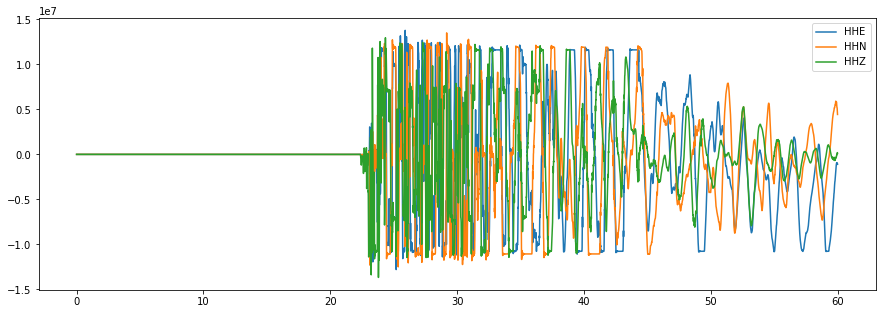

In [4]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("INGV")

t = UTCDateTime(2009, 4, 6, 1, 32)
stream = client.get_waveforms(network="MN", station="AQU", location="*", channel="HH?", starttime=t+20, endtime=t+80)
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()

In [5]:
stream

3 Trace(s) in Stream:
MN.AQU..HHE | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHN | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples
MN.AQU..HHZ | 2009-04-06T01:32:19.998597Z - 2009-04-06T01:33:19.998597Z | 100.0 Hz, 6001 samples

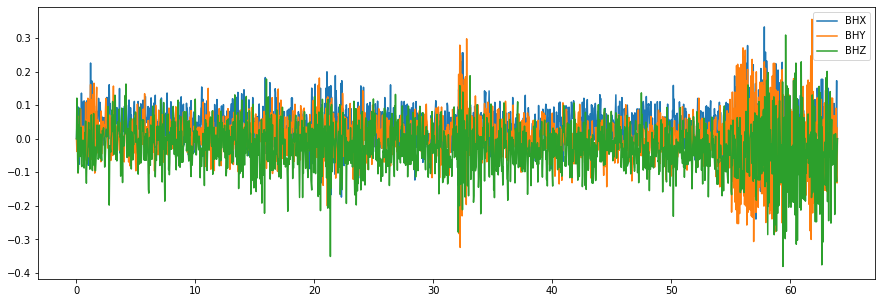

In [6]:
stream = obspy.read('data/signal/1512130231_005_P.mseed')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()


In [7]:
stream

3 Trace(s) in Stream:
.005..BHX | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHY | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples
.005..BHZ | 2017-12-01T12:10:31.032000Z - 2017-12-01T12:11:35.000000Z | 31.2 Hz, 2000 samples

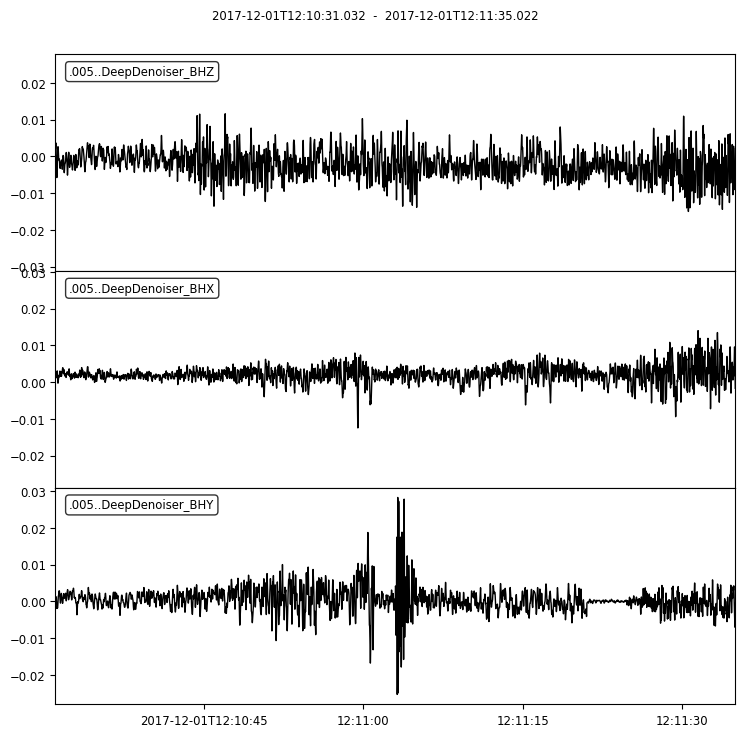

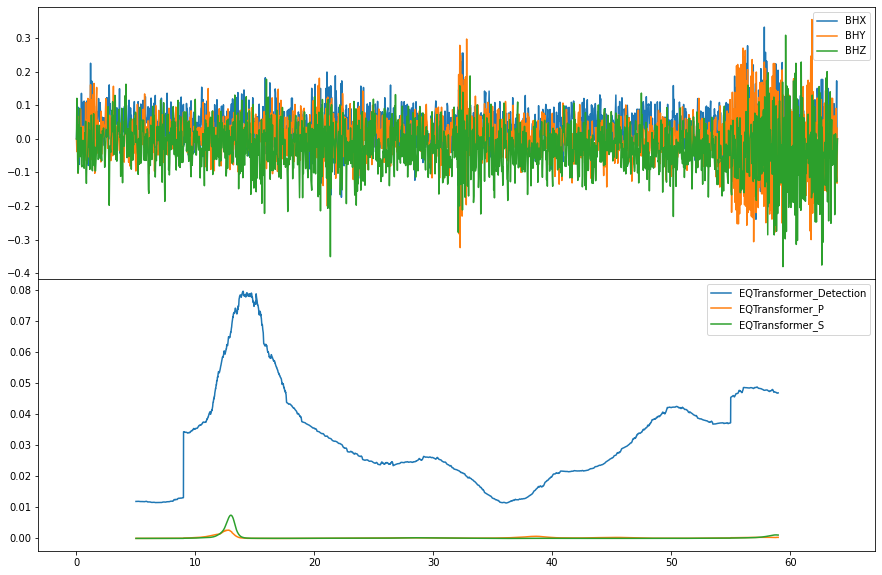

In [8]:
model = sbm.DeepDenoiser.from_pretrained("original")
annotations = model.annotate(stream)
annotations.plot()

picker = sbm.EQTransformer.from_pretrained("stead")

annotations = picker.annotate(annotations,strict=False)
annotations

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

offset = annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

In [34]:
def trainnetwork(train_in, train_target, test_in, test_target, filename = 'earthquake.mseed'):
    train_in  = train_in
    train_target = train_target
    test_in  = test_in
    test_target = test_target
    batch_size = 32
    
    # Kernel initializer
    my_init = keras.initializers.glorot_uniform(seed=1)
    # Define neural network architecture
    model = keras.Sequential([
        # Input layer, do not change
        tf.keras.layers.InputLayer(input_shape=(train_in.shape[1],train_in.shape[2],)),
        # Inner layers, can add/change
        keras.layers.Dense(32,  activation='tanh',kernel_initializer=my_init),
        #keras.layers.Dense(16,  activation='tanh',kernel_initializer=my_init),
        #keras.layers.Dense(8,  activation='tanh',kernel_initializer=my_init),
        # Output layer, do not change
        keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

    model.compile(
        # Optimization algorithm, specify learning rate
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        # Loss function for a binary classifier
        loss='binary_crossentropy',
        # Diagnostic quantities
        metrics=['accuracy'])

    # Decrease the learning rate exponentially after the first 10 epochs
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.05)

    # Actual Training
    history = model.fit(
        # Training inputs
        train_in,
        # Training outputs
        train_target,
        # Evaluate test set at each epoch
        validation_data=(test_in, test_target),
        # Batch size, default is 32
        batch_size=batch_size,
        # Number of epochs
        epochs=150,
        # Store the model with the best validation accuracy
        callbacks = [
            # Drecrease learning rate
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            # Store the model with the best validation accuracy
            tf.keras.callbacks.ModelCheckpoint(
                filepath=filename,
                save_weights_only=False,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True),
            # Save logfiles for tensorboard
            tf.keras.callbacks.TensorBoard(log_dir="logs"+filename.split('.mseed')[0], histogram_freq=1)],
        # Shuffle data at each epoch
        shuffle=True)

    # Store the last (not necessarily the best) iteration
    #model.save(filename)

    model = loadnetwork(filename)
    return model

In [19]:
signalfiles = [f for f in listdir(signalpath) if isfile(join(signalpath, f))]
noisefiles = [f for f in listdir(noisepath) if isfile(join(noisepath, f))]

In [67]:
signaldata= [obspy.read(signalpath + signalfiles[i]) for i in range(len(signalfiles))] 
signal = [[signaldata[i][0].data, signaldata[i][1].data, signaldata[i][2].data] for i in range(len(signaldata))]
noisedata = [obspy.read(noisepath + noisefiles[i]) for i in range(len(noisefiles))] 
noise = [[noisedata[i][0].data, noisedata[i][1].data, noisedata[i][2].data] for i in range(len(noisedata))]
data = np.concatenate((signal, noise))
target = np.array([1 for i in range(len(signal))]+[0 for i in range(len(noise))])

In [68]:
np.random.seed(0)
train_idx = np.random.choice(np.arange(0, len(data)), int(len(data)*0.7))
train_data = data[train_idx]
train_y = target[train_idx]
test_data = data[~train_idx]
test_y = target[~train_idx]

In [69]:
trainnetwork(train_data,train_y,test_data,test_y)

ValueError: Error when checking input: expected input_14 to have 4 dimensions, but got array with shape (13351, 3, 2000)

In [39]:
model = keras.Sequential([
    # Input layer, do not change
    tf.keras.layers.InputLayer(input_shape=(train_data.shape[1],train_data.shape[2],)),
    # Inner layers, can add/change
    keras.layers.Dense(32,  activation='tanh'),
    #keras.layers.Dense(16,  activation='tanh',kernel_initializer=my_init),
    #keras.layers.Dense(8,  activation='tanh',kernel_initializer=my_init),
    # Output layer, do not change
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    # Optimization algorithm, specify learning rate
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    # Loss function for a binary classifier
    loss='binary_crossentropy',
    # Diagnostic quantities
    metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 3, 32)             64032     
_________________________________________________________________
dense_21 (Dense)             (None, 3, 1)              33        
Total params: 64,065
Trainable params: 64,065
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.fit(train_data, train_y, epochs = 200, batch_size = 64)

ValueError: A target array with shape (13351, 1) was passed for an output of shape (None, 3, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [57]:
target = target.reshape(1,-1)

In [66]:
train_y.shape

(1, 13351)